In [1]:
#### Homework Assignment 1: Adversarial Examples

## This jupyter notebook aims to get familiar with the untargted and targeted methods for generating adversarial examples
## We will try to attack a pretrained ImageNet ResNet50 model on a given ImageNet image .

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

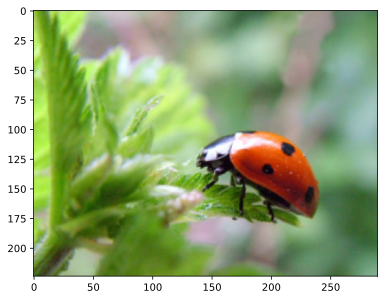

In [2]:
## Load the sample ImageNet image (which is an image of ladybug) and visualize it 

from PIL import Image
import sympy
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
ladybug_img = Image.open("ladybug.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
ladybug_tensor = preprocess(ladybug_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(ladybug_tensor[0].numpy().transpose(1,2,0))

In [3]:
## Prepare the ImageNet ResNet50 classification model
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode
model = resnet50(pretrained=True)
model.eval()

C:\Users\I2SC-Hamayoon\Documents\GitHub\RMLHWs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\I2SC-Hamayoon\Documents\GitHub\RMLHWs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# form the prediction on the clean ladybug image
pred_ladybug = model(norm(ladybug_tensor))
print(imagenet_classes[pred_ladybug.max(dim=1)[1].item()])

ladybug


In [5]:
# 301 is the class index corresponding to the ImageNet class "ladybug"
# form the cross-entropy loss on the prediction according to the ground truth label
print(nn.CrossEntropyLoss()(model(norm(ladybug_tensor)),torch.LongTensor([301])).item())

0.07101987302303314


In [6]:
## Your task 1: implement the simple version of untargeted PGD attack - make necessary changes to the following code
import torch.optim as optim

epsilon = 2./255
alpha = 0.01

# delta stores the generated perturbation and updates its value iteratively
delta = torch.zeros_like(ladybug_tensor, requires_grad=True)

for t in range(30):
    pred = model(norm(ladybug_tensor + delta))
    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([301]))
    loss.backward()
    delta.data = (delta + alpha*torch.sign(delta.grad.data)).clamp(-epsilon, epsilon) 
    delta.grad.zero_()
    if t % 5 == 0:
        print(t, loss.item())

# pred stores the model predicted logits of the genreated adversarial example
print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

0 0.07101987302303314
5 7.769709587097168
10 8.94502067565918
15 9.986440658569336
20 12.438157081604004
25 10.335768699645996
True class probability: 2.4333428882528096e-05


In [7]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  leaf_beetle
Predicted probability: 0.9995362758636475


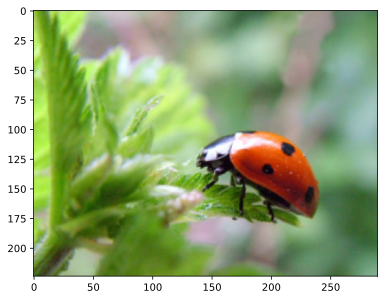

In [8]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


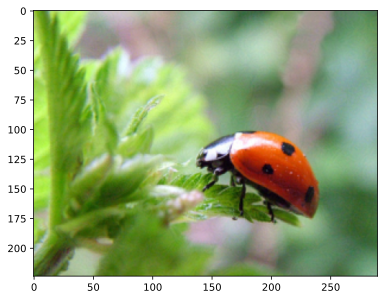

In [9]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

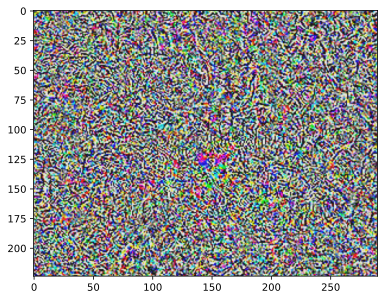

In [10]:
# plot the generated adversarial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [11]:
## Your task 2: implement the basic version of targeted attack - make necessary changes to the following code
## Targeted label: zebra; Class index: 340

delta = torch.zeros_like(ladybug_tensor, requires_grad=True)
alpha = 0.01

for t in range(100):
    pred = model(norm(ladybug_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([340]))
    loss.backward()
    perturbation = alpha*torch.sign(delta.grad.data)
    delta.data = (delta - perturbation).clamp(-epsilon, epsilon)
 
    if t % 10 == 0:
        print(t, loss.item())

print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())
print("Target class probability:", nn.Softmax(dim=1)(pred)[0,340].item())

0 -19.54692840576172
10 -53.59999465942383
20 -66.5893325805664
30 -73.41336822509766
40 -79.322509765625
50 -81.78508758544922
60 -83.6981201171875
70 -85.70380401611328
80 -87.45912170410156
90 -87.78211212158203
True class probability: 0.999976396560669
Target class probability: 2.6428587128058553e-39


In [12]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  ladybug
Predicted probability: 0.999976396560669


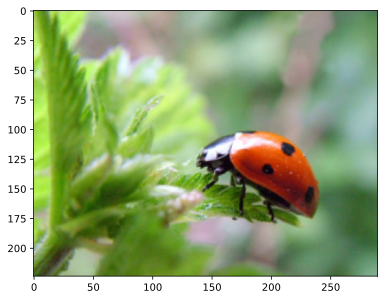

In [13]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


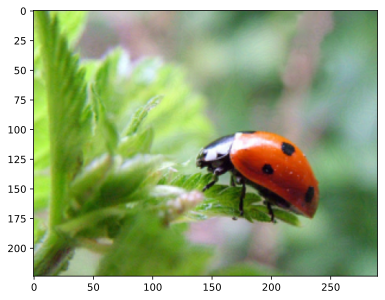

In [14]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

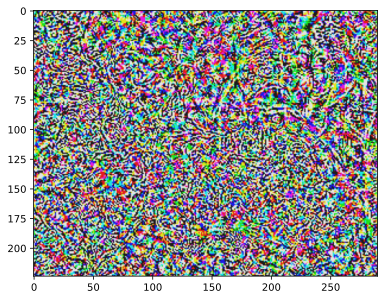

In [15]:
# plot the generated adversasrial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))